In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# Add src to path
import sys
sys.path.append('..')

from src.config import FEATURED_DATA_PATH, SELECTED_DATA_PATH, TARGET_COLUMN, DATE_COLUMN
from src.feature_selection import (
    get_lstm_feature_categories, get_available_features,
    check_for_leakage_features, select_features_for_lstm,
    correlation_with_target, remove_highly_correlated,
    feature_selection_pipeline
)
from src.utils import save_csv, save_json

print("Libraries imported successfully!")
print("\nLSTM-safe feature categories:")
for cat, feats in get_lstm_feature_categories().items():
    print(f"  {cat}: {feats}")

Libraries imported successfully!

LSTM-safe feature categories:
  cyclical: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
  temporal: ['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'week_of_year', 'quarter', 'season']
  context: ['is_weekend', 'is_rush_hour']
  weather: ['temp', 'temp_celsius', 'clouds_all', 'rain_1h', 'snow_1h', 'is_rainy', 'is_snowy']
  interaction: ['rush_rain']


## 4.1 Load Featured Data

In [2]:
# Load featured data
df = pd.read_csv(FEATURED_DATA_PATH, parse_dates=[DATE_COLUMN])
print(f"Loaded data shape: {df.shape}")
print(f"Number of features: {df.shape[1] - 1}")

Loaded data shape: (40575, 43)
Number of features: 42


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40575 entries, 0 to 40574
Data columns (total 43 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date_time            40575 non-null  datetime64[ns]
 1   temp                 40575 non-null  float64       
 2   rain_1h              40575 non-null  float64       
 3   snow_1h              40575 non-null  float64       
 4   clouds_all           40575 non-null  float64       
 5   traffic_volume       40575 non-null  float64       
 6   weather_description  40575 non-null  object        
 7   holiday              40575 non-null  int64         
 8   Clear                40575 non-null  int64         
 9   Clouds               40575 non-null  int64         
 10  Drizzle              40575 non-null  int64         
 11  Fog                  40575 non-null  int64         
 12  Haze                 40575 non-null  int64         
 13  Mist                 40575 non-

In [4]:
# Check available features by category
available_features = get_available_features(df, TARGET_COLUMN, DATE_COLUMN)

print("Available features in dataset:")
for category, feats in available_features.items():
    if feats:
        print(f"\n{category.upper()} ({len(feats)}):")
        for f in feats:
            print(f"  - {f}")

Available features in dataset:

CYCLICAL (6):
  - hour_sin
  - hour_cos
  - day_sin
  - day_cos
  - month_sin
  - month_cos

TEMPORAL (8):
  - hour
  - day_of_week
  - day_of_month
  - month
  - year
  - week_of_year
  - quarter
  - season

CONTEXT (2):
  - is_weekend
  - is_rush_hour

WEATHER (7):
  - temp
  - temp_celsius
  - clouds_all
  - rain_1h
  - snow_1h
  - is_rainy
  - is_snowy

INTERACTION (1):
  - rush_rain


## 4.2 Select Features for LSTM

For LSTM Encoder-Decoder, we select features that:
- ✅ Are safe from data leakage
- ✅ Provide temporal context (cyclical encoding)
- ✅ Include weather/environmental factors

In [5]:
# Select features using LSTM-optimized pipeline
selected_features, selection_info = select_features_for_lstm(
    df, 
    target_col=TARGET_COLUMN,
    date_col=DATE_COLUMN,
    multicollinearity_threshold=0.95
)

print(f"\n✅ Selected {len(selected_features)} features for LSTM:")
for i, feat in enumerate(selected_features):
    print(f"  {i+1:2d}. {feat}")

LSTM Feature Selection
  cyclical: 6 features - ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
  temporal: 8 features - ['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'week_of_year', 'quarter', 'season']
  context: 2 features - ['is_weekend', 'is_rush_hour']
  weather: 7 features - ['temp', 'temp_celsius', 'clouds_all', 'rain_1h', 'snow_1h', 'is_rainy', 'is_snowy']
  interaction: 1 features - ['rush_rain']

Total features before filtering: 24
Removed 3 highly correlated features (>0.95)
Dropped: ['week_of_year', 'quarter', 'temp_celsius']
Selected 21 features for LSTM

✅ Selected 21 features for LSTM:
   1. hour_sin
   2. hour_cos
   3. day_sin
   4. day_cos
   5. month_sin
   6. month_cos
   7. hour
   8. day_of_week
   9. day_of_month
  10. month
  11. year
  12. season
  13. is_weekend
  14. is_rush_hour
  15. temp
  16. clouds_all
  17. rain_1h
  18. snow_1h
  19. is_rainy
  20. is_snowy
  21. rush_rain


## 4.3 Correlation Analysis

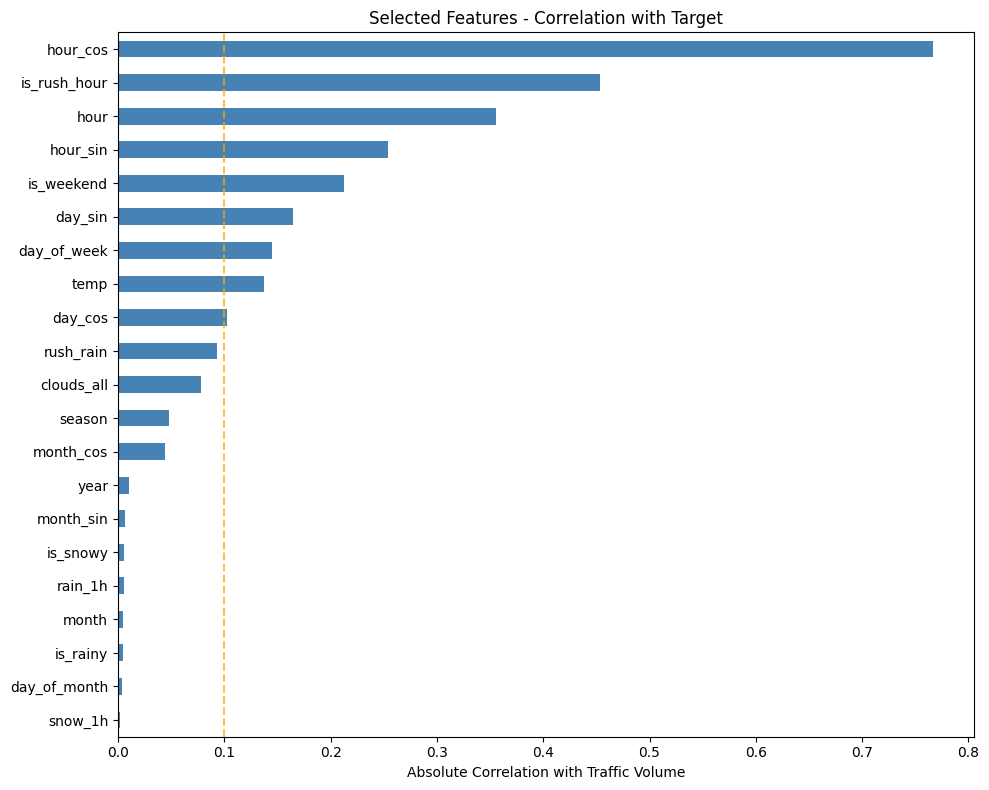

In [6]:
# Correlation with target
correlations = selection_info['correlations']

# Visualize correlations
fig, ax = plt.subplots(figsize=(10, 8))
correlations.sort_values().plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Absolute Correlation with Traffic Volume')
ax.set_title('Selected Features - Correlation with Target')
ax.axvline(x=0.1, color='orange', linestyle='--', alpha=0.7, label='Threshold 0.1')
plt.tight_layout()
plt.show()

## 4.4 Feature Categories Visualization

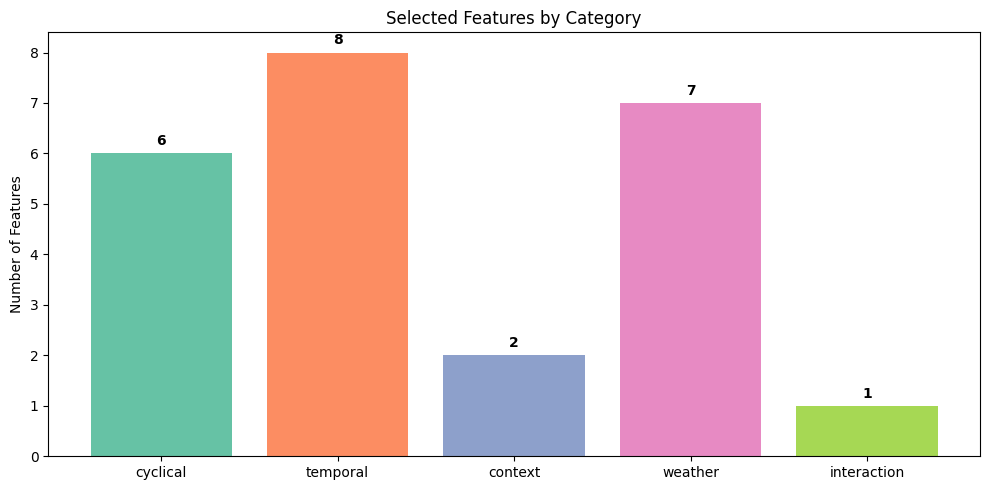


Features by category:
  cyclical: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos']
  temporal: ['hour', 'day_of_week', 'day_of_month', 'month', 'year', 'week_of_year', 'quarter', 'season']
  context: ['is_weekend', 'is_rush_hour']
  weather: ['temp', 'temp_celsius', 'clouds_all', 'rain_1h', 'snow_1h', 'is_rainy', 'is_snowy']
  interaction: ['rush_rain']


In [7]:
# Visualize features by category
category_counts = {cat: len(feats) for cat, feats in selection_info['categories'].items() if feats}

fig, ax = plt.subplots(figsize=(10, 5))
colors = plt.cm.Set2(range(len(category_counts)))
bars = ax.bar(category_counts.keys(), category_counts.values(), color=colors)
ax.set_ylabel('Number of Features')
ax.set_title('Selected Features by Category')

# Add value labels
for bar, count in zip(bars, category_counts.values()):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nFeatures by category:")
for cat, feats in selection_info['categories'].items():
    if feats:
        print(f"  {cat}: {feats}")

## 4.5 Create Final Dataset

In [8]:
# Create final dataset with selected features
# Include: date_time, target, selected features
final_cols = [DATE_COLUMN, TARGET_COLUMN] + selected_features
df_selected = df[final_cols].copy()

print(f"Final dataset shape: {df_selected.shape}")
print(f"Columns: {df_selected.columns.tolist()}")
df_selected.head()

Final dataset shape: (40575, 23)
Columns: ['date_time', 'traffic_volume', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'hour', 'day_of_week', 'day_of_month', 'month', 'year', 'season', 'is_weekend', 'is_rush_hour', 'temp', 'clouds_all', 'rain_1h', 'snow_1h', 'is_rainy', 'is_snowy', 'rush_rain']


,date_time,traffic_volume,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,hour,day_of_week,...,season,is_weekend,is_rush_hour,temp,clouds_all,rain_1h,snow_1h,is_rainy,is_snowy,rush_rain
0,2012-10-02 09:00:00,5545.0,7.071068e-01,-0.707107,0.781831,0.62349,-0.866025,0.5,9,1,...,2,0,1,288.28,40.0,0.0,0.0,0,0,0
1,2012-10-02 10:00:00,4516.0,5.000000e-01,-0.866025,0.781831,0.62349,-0.866025,0.5,10,1,...,2,0,0,289.36,75.0,0.0,0.0,0,0,0
2,2012-10-02 11:00:00,4767.0,2.588190e-01,-0.965926,0.781831,0.62349,-0.866025,0.5,11,1,...,2,0,0,289.58,90.0,0.0,0.0,0,0,0
3,2012-10-02 12:00:00,5026.0,1.224647e-16,-1.000000,0.781831,0.62349,-0.866025,0.5,12,1,...,2,0,0,290.13,90.0,0.0,0.0,0,0,0
4,2012-10-02 13:00:00,4918.0,-2.588190e-01,-0.965926,0.781831,0.62349,-0.866025,0.5,13,1,...,2,0,0,291.14,75.0,0.0,0.0,0,0,0


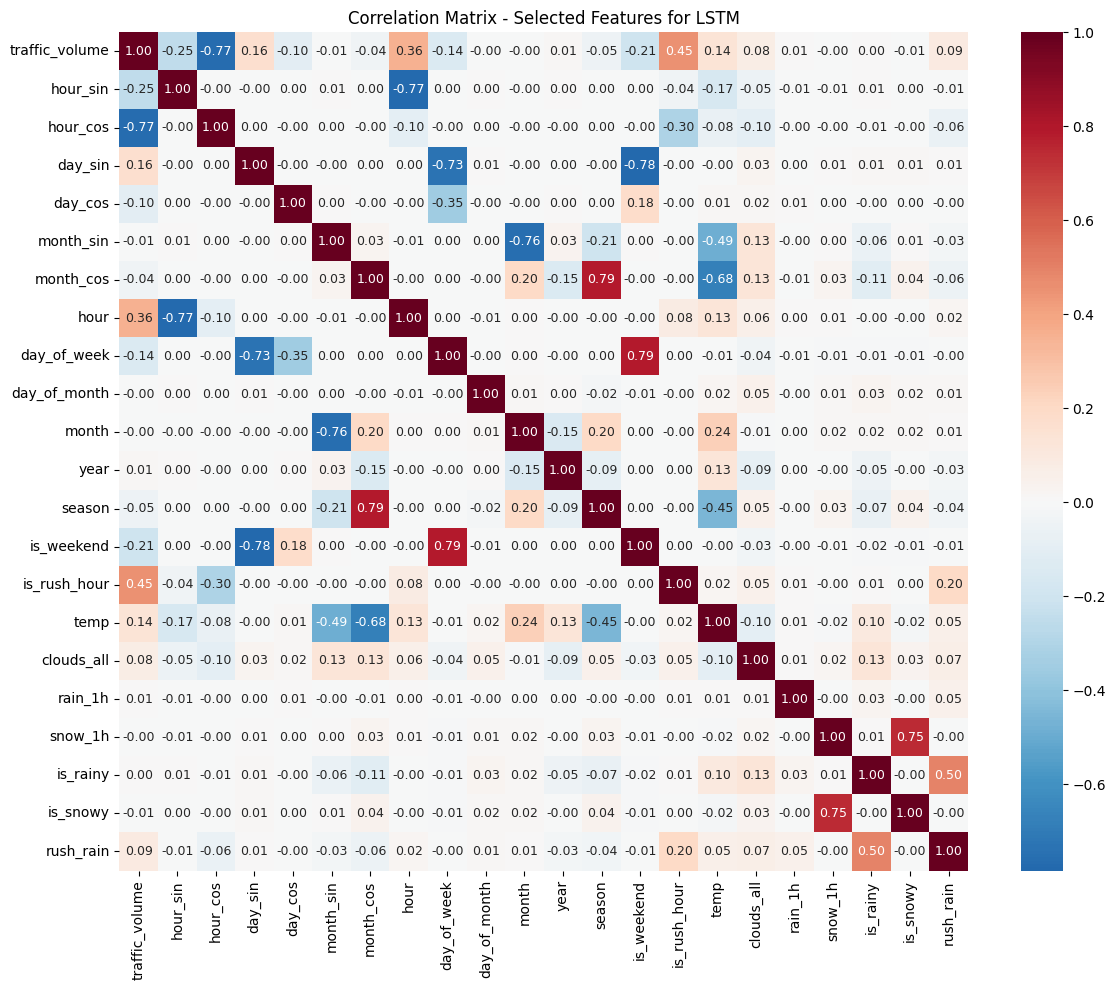

In [9]:
# Correlation matrix of selected features
fig, ax = plt.subplots(figsize=(12, 10))
corr_matrix = df_selected.drop(columns=[DATE_COLUMN]).corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, ax=ax, 
            fmt='.2f', annot_kws={'size': 9})
ax.set_title('Correlation Matrix - Selected Features for LSTM')
plt.tight_layout()
plt.show()

## 4.6 Save Selected Features Data

In [10]:
# Save selected features data
save_csv(df_selected, SELECTED_DATA_PATH, index=False)

# Save feature info
import os
feature_info = {
    'selected_features': selected_features,
    'n_features': len(selected_features),
    'target': TARGET_COLUMN,
    'categories': {cat: feats for cat, feats in selection_info['categories'].items() if feats},
    'correlations': selection_info['correlations'].to_dict(),
    'note': 'Features selected for LSTM - no lag/rolling/diff to avoid data leakage'
}

save_json(feature_info, os.path.join(os.path.dirname(SELECTED_DATA_PATH), 'selected_features_info.json'))

print(f"✅ Selected features data saved to: {SELECTED_DATA_PATH}")
print(f"✅ Feature info saved to: selected_features_info.json")

Saved: d:\DeepLearning_final\data\processed\selected_features.csv
Saved: d:\DeepLearning_final\data\processed\selected_features_info.json
✅ Selected features data saved to: d:\DeepLearning_final\data\processed\selected_features.csv
✅ Feature info saved to: selected_features_info.json


## Summary

**Feature Selection for LSTM Encoder-Decoder completed:**

1. ✅ Identified LSTM-safe feature categories
2. ✅ Selected features without data leakage
3. ✅ Removed multicollinear features
4. ✅ Saved selected features data

**Selected feature categories:**
- **Cyclical**: hour_sin/cos, day_sin/cos, month_sin/cos (encode temporal patterns)
- **Temporal**: hour, day_of_week, month, season, etc.
- **Context**: is_weekend, is_rush_hour
- **Weather**: temp, clouds_all, rain_1h, snow_1h, etc.
- **Interaction**: rush_rain


**Next step:** Data Preparation (05_Data_Preparation.ipynb)